In [1]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import export_text
from sklearn import tree

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [102]:
from sklearn.metrics import roc_curve

In [3]:
df = pd.read_csv('clean_data_xtra_features_for_cancelation.csv')
df = df.dropna(axis=0)
df = df.drop(columns=['Unnamed: 0'], axis=1)

In [4]:
df.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,gds_channel,ta_to_channel,no_deposit,refundable_deposit,nonrefundable_deposit,with_company,is_contract,is_group,is_transient,is_transient_party
0,0,342,7,27,1,0,0,2,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,737,7,27,1,0,0,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0,7,7,27,1,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,13,7,27,1,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,14,7,27,1,0,2,2,0,0,...,0,1,1,0,0,0,0,0,1,0


In [5]:
def make_dataset(df, features, test_size=.3, normalize = True, binned= False):
    X = df.loc[:,features].values
    if normalize:
        X = MinMaxScaler().fit_transform(X)
    if binned:
        y = df['is_canceled'].values
        bin_edges = np.linspace(np.min(y), np.max(y), 20)
        y_bin = np.zeros(np.shape(y))
        for i in range(len(y)):
            for j in range(len(bin_edges)):
                if y[i] < bin_edges[j]:
                    y_bin[i] = j
                    break
        y = y_bin
    else:
        y = df['is_canceled'].values
        
    assert(len(X) == len(y))
    
    print("Total Size of data: ", len(X))
    
    test_size = int(len(X)*test_size)
    ind = [np.random.choice(range(len(X)), size=test_size, replace=False)]
    X_test = X[ind]
    y_test = y[ind]
    X_train = np.delete(X, ind, axis=0)
    y_train = np.delete(y, ind)
    
    print("Feature", features)
    print("X_train: ", np.shape(X_train))
    print("y_train: ", np.shape(y_train))
    print("X_test: ", np.shape(X_test))
    print("y_test: ", np.shape(y_test))
    
    return X_train, y_train, X_test, y_test
def make_PCA(X_train, X_test, features, thresh = .90):
    pca = PCA(thresh)
    pca.fit(X_train)
    
    var = pca.explained_variance_ratio_
    print("number components: ", len(var))
    evar = np.sum(var)
    print("Explained Variance:", evar)
    
    X_pcs_train = pca.transform(X_train)
    X_pcs_test = pca.transform(X_test)
    
    n_pcs= pca.components_.shape[0]
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

    initial_feature_names = features
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
    
    return X_pcs_train, X_pcs_test, dic


def make_dataset_with_valid(df, features, test_size=.3, valid_size = 0.3, normalize = True, binned= False):
    X = df.loc[:,features].values
    if normalize:
        X = MinMaxScaler().fit_transform(X)
    if binned:
        y = df['is_canceled'].values
        bin_edges = np.linspace(np.min(y), np.max(y), 20)
        y_bin = np.zeros(np.shape(y))
        for i in range(len(y)):
            for j in range(len(bin_edges)):
                if y[i] < bin_edges[j]:
                    y_bin[i] = j
                    break
        y = y_bin
    else:
        y = df['is_canceled'].values
        
    assert(len(X) == len(y))
    
    print("Total Size of data: ", len(X))
    
    test_size = int(len(X)*test_size)
    ind = [np.random.choice(range(len(X)), size=test_size, replace=False)]
    X_test = X[ind]
    y_test = y[ind]
    X_train = np.delete(X, ind, axis=0)
    y_train = np.delete(y, ind)
    
    ind = [np.random.choice(range(len(X_train)), size=test_size, replace=False)]
    X_valid = X_train[ind]
    y_valid = y_train[ind]
    X_train = np.delete(X_train, ind, axis=0)
    y_train = np.delete(y_train, ind)
    
    
    print("Feature", features)
    print("X_train: ", np.shape(X_train))
    print("y_train: ", np.shape(y_train))
    print("X_valid: ", np.shape(X_valid))
    print("y_valid: ", np.shape(y_valid))
    print("X_test: ", np.shape(X_test))
    print("y_test: ", np.shape(y_test))
    
    
    return X_train, y_train,X_valid, y_valid, X_test, y_test

### Logistic Regression Without PCA for Cancellations

In [6]:
features = list(df.columns)
features.remove('is_canceled')
X_train, y_train, X_test, y_test = make_dataset(df, features, binned=False)

Total Size of data:  118215
Feature ['lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'is_resort', 'bought_meal', 'is_international', 'aviation_segment', 'corporate_segment', 'groups_segment', 'offline_ta_to_segment', 'online_ta_segment', 'corporate_channel', 'direct_channel', 'gds_channel', 'ta_to_channel', 'no_deposit', 'refundable_deposit', 'nonrefundable_deposit', 'with_company', 'is_contract', 'is_group', 'is_transient', 'is_transient_party']
X_train:  (82751, 36)
y_train:  (82751,)
X_test:  (35464, 36)
y_test:  (35464,)


C:\Users\KATYLU~2\AppData\Local\Temp/ipykernel_31824/4070631666.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test = X[ind]
C:\Users\KATYLU~2\AppData\Local\Temp/ipykernel_31824/4070631666.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_test = y[ind]


In [7]:
lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)

In [8]:
lr.score(X_test, y_test)

0.800304534175502

### Logistic Regression With PCA for Cancellations

In [9]:
features = list(df.columns)
features.remove('is_canceled')
X_train, y_train, X_test, y_test = make_dataset(df, features, binned=False)
X_train_pca, X_test_pca, col_dic = make_PCA(X_train, X_test, features, thresh=.999)

Total Size of data:  118215
Feature ['lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'is_resort', 'bought_meal', 'is_international', 'aviation_segment', 'corporate_segment', 'groups_segment', 'offline_ta_to_segment', 'online_ta_segment', 'corporate_channel', 'direct_channel', 'gds_channel', 'ta_to_channel', 'no_deposit', 'refundable_deposit', 'nonrefundable_deposit', 'with_company', 'is_contract', 'is_group', 'is_transient', 'is_transient_party']
X_train:  (82751, 36)
y_train:  (82751,)
X_test:  (35464, 36)
y_test:  (35464,)
number components:  27
Explained Variance: 0.9990240065657803


C:\Users\KATYLU~2\AppData\Local\Temp/ipykernel_31824/4070631666.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test = X[ind]
C:\Users\KATYLU~2\AppData\Local\Temp/ipykernel_31824/4070631666.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_test = y[ind]


In [10]:
lr = LogisticRegression(max_iter=10000).fit(X_train_pca, y_train)

In [11]:
lr.score(X_test_pca, y_test)

0.7972873900293255

In [12]:
col_dic

{'PC0': 'online_ta_segment',
 'PC1': 'ta_to_channel',
 'PC2': 'is_international',
 'PC3': 'offline_ta_to_segment',
 'PC4': 'is_resort',
 'PC5': 'arrival_date_month',
 'PC6': 'groups_segment',
 'PC7': 'direct_channel',
 'PC8': 'arrival_date_day_of_month',
 'PC9': 'bought_meal',
 'PC10': 'required_car_parking_spaces',
 'PC11': 'is_contract',
 'PC12': 'no_deposit',
 'PC13': 'is_repeated_guest',
 'PC14': 'total_of_special_requests',
 'PC15': 'with_company',
 'PC16': 'lead_time',
 'PC17': 'corporate_segment',
 'PC18': 'adr',
 'PC19': 'is_group',
 'PC20': 'corporate_segment',
 'PC21': 'stays_in_weekend_nights',
 'PC22': 'gds_channel',
 'PC23': 'aviation_segment',
 'PC24': 'children',
 'PC25': 'refundable_deposit',
 'PC26': 'previous_cancellations'}

## KNN

In [13]:
X_train, y_train, X_valid, y_valid, X_test, y_test = make_dataset_with_valid(df, features,normalize = True, binned=False)

Total Size of data:  118215
Feature ['lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'is_resort', 'bought_meal', 'is_international', 'aviation_segment', 'corporate_segment', 'groups_segment', 'offline_ta_to_segment', 'online_ta_segment', 'corporate_channel', 'direct_channel', 'gds_channel', 'ta_to_channel', 'no_deposit', 'refundable_deposit', 'nonrefundable_deposit', 'with_company', 'is_contract', 'is_group', 'is_transient', 'is_transient_party']
X_train:  (47287, 36)
y_train:  (47287,)
X_valid:  (35464, 36)
y_valid:  (35464,)
X_test:  (35464, 36)
y_test:  (35464,)


C:\Users\KATYLU~2\AppData\Local\Temp/ipykernel_31824/4070631666.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  X_test = X[ind]
C:\Users\KATYLU~2\AppData\Local\Temp/ipykernel_31824/4070631666.py:80: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y_test = y[ind]
C:\Users\KATYLU~2\AppData\Local\Temp/ipykernel_31824/4070631666.py:85: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq

In [14]:
bestk = 1
bestscore = 0
bestmodel = None
for i in range(1,15):
    model = KNeighborsClassifier(n_neighbors = i, algorithm = 'ball_tree')
    model.fit(X_train, y_train)
    score = model.score(X_valid, y_valid)
    if(score > bestscore):
        bestk = i
        bestmodel=model
        bestscore = score

In [15]:
bestmodel.score(X_test, y_test)

0.82776900518836

In [16]:
bestk

5

In [78]:
cm = confusion_matrix(y_test, bestmodel.predict(X_test), normalize= 'all')

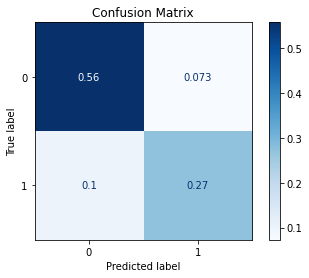

In [89]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay(cm).plot(cmap='Blues', ax = ax)
ax.set_title("Confusion Matrix")
plt.show()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118215 entries, 0 to 118214
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118215 non-null  int64  
 1   lead_time                       118215 non-null  int64  
 2   arrival_date_month              118215 non-null  int64  
 3   arrival_date_week_number        118215 non-null  int64  
 4   arrival_date_day_of_month       118215 non-null  int64  
 5   stays_in_weekend_nights         118215 non-null  int64  
 6   stays_in_week_nights            118215 non-null  int64  
 7   adults                          118215 non-null  int64  
 8   children                        118215 non-null  int64  
 9   babies                          118215 non-null  int64  
 10  is_repeated_guest               118215 non-null  int64  
 11  previous_cancellations          118215 non-null  int64  
 12  previous_booking

Text(0.5, 0, 'No                                                      Yes')

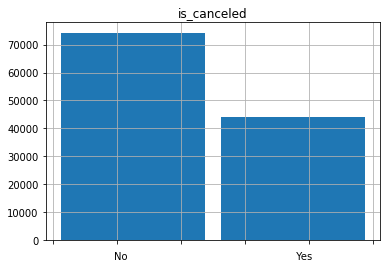

In [60]:
fig, ax = plt.subplots()
df.hist("is_canceled", bins = 2, rwidth=0.9, ax = ax)
ax.set_xticklabels("")
ax.set_xlabel("No                                                      Yes")

In [104]:
1- sum(df["is_canceled"])/len(df["is_canceled"])

0.6283635748424481

In [91]:
len(df["is_canceled"])

118215

In [94]:
from sklearn.metrics import f1_score

In [95]:
bestk = 1
bestscore = 0
bestmodel = None
for i in range(1,15):
    model = KNeighborsClassifier(n_neighbors = i, algorithm = 'ball_tree')
    model.fit(X_train, y_train)
    score = f1_score(model.predict(X_valid), y_valid)
    if(score > bestscore):
        bestk = i
        bestmodel=model
        bestscore = score

In [96]:
bestmodel.score(X_test, y_test)

0.8259079630047372

In [101]:
f1_score(model.predict(X_test), y_test)

0.7444913659739935

In [97]:
bestk

3

In [98]:
cm = confusion_matrix(y_test, bestmodel.predict(X_test), normalize= 'all')

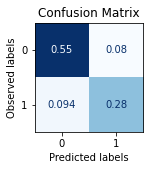

In [126]:
fig, ax = plt.subplots(figsize = (2,2))
ConfusionMatrixDisplay(cm).plot(cmap='Blues', ax = ax, colorbar = False)
#label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels')#, fontdict=label_font)
ax.set_ylabel('Observed labels')#, fontdict=label_font)
#ax.set_xticks([0,1], fontdict=label_font)
#ax.set_yticks([0,1], fontdict=label_font)
ax.set_title("Confusion Matrix")#, fontdict=label_font)
plt.show()

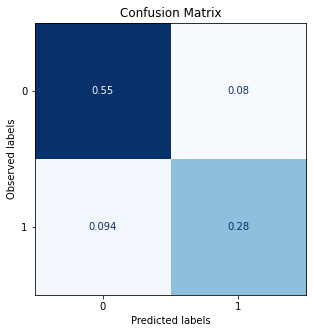

In [129]:
fig, ax = plt.subplots(figsize = (5,5))
ConfusionMatrixDisplay(cm).plot(cmap='Blues', ax = ax, colorbar = False)
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels')#, fontdict=label_font)
ax.set_ylabel('Observed labels')#, fontdict=label_font)
ax.set_xticks([0,1], fontdict=label_font)
ax.set_yticks([0,1], fontdict=label_font)
ax.set_title("Confusion Matrix")#, fontdict=label_font)
plt.show()